In [63]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [64]:
cd /content/gdrive/My Drive/Sentiment_Analysis_Rotten_Tomatoes/

/content/gdrive/My Drive/Sentiment_Analysis_Rotten_Tomatoes


In [65]:
!python3 -m pip install pyspellchecker

In [0]:
import numpy as np
import pandas as pd
import string, re
from unicodedata import category, name, normalize
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import gensim
from gensim.models.word2vec import Word2Vec

from tqdm import tqdm_notebook as tqdm

In [67]:
train = pd.read_csv('train.tsv',sep='\t')
train.shape

(156060, 4)

In [68]:
train.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [69]:
train['Phrase'][:10].values

array(['A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
       'A series of escapades demonstrating the adage that what is good for the goose',
       'A series', 'A', 'series',
       'of escapades demonstrating the adage that what is good for the goose',
       'of',
       'escapades demonstrating the adage that what is good for the goose',
       'escapades',
       'demonstrating the adage that what is good for the goose'],
      dtype=object)

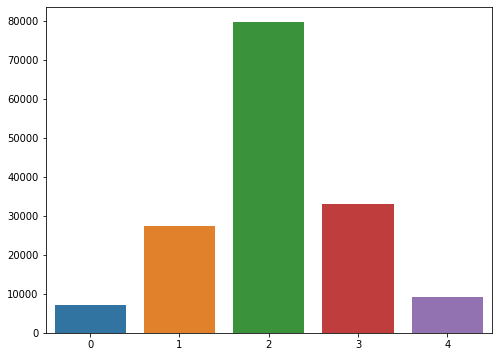

In [70]:
vc = train.Sentiment.value_counts()
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(vc.keys(), vc.values)

In [0]:
# remove space
def remove_space(text):
    spaces = ['\u200b', '\u200e', '\u202a', '\u202c', '\ufeff', '\uf0d8', '\u2061', '\x10', '\x7f', '\x9d', '\xad', '\xa0']
    for space in spaces:
        text = text.replace(space, ' ')
    text = text.strip()
    text = re.sub('\s+', ' ', text)
    return text

#critics
def remove_diacritics(s):
    return ''.join(c for c in normalize('NFKD', s.replace('ø', 'o').replace('Ø', 'O').replace('⁻', '-').replace('₋', '-'))
                  if category(c) != 'Mn')

#clearn punctuations
def clean_special_punctuations(text):
    special_punc_mappings = {"—": "-", "–": "-", "_": "-", '”': '"', "″": '"', '“': '"', '•': '.', '−': '-',
                         "’": "'", "‘": "'", "´": "'", "`": "'", '\u200b': ' ', '\xa0': ' ','،':'','„':'',
                         '…': ' ... ', '\ufeff': ''}
    for punc in special_punc_mappings:
        if punc in text:
            text = text.replace(punc, special_punc_mappings[punc])
    text = remove_diacritics(text)
    return text

# clean numbers
def clean_number(text):
    text = re.sub(r'(\d+)([a-zA-Z])', '\g<1> \g<2>', text) # digits followed by a single alphabet...
    text = re.sub(r'(\d+) (th|st|nd|rd) ', '\g<1>\g<2> ', text) #1st, 2nd, 3rd, 4th...
    text = re.sub(r'(\d+),(\d+)', '\g<1>\g<2>', text)
    return text

# emojis
def handle_emojis(text):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', text)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', text)
    # Love -- <3, :*
    text = re.sub(r'(<3|:\*)', ' EMO_POS ', text)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    text = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', text)
    # Sad -- :-(, : (, :(, ):, )-:
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', text)
    # Cry -- :,(, :'(, :"(
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', text)
    return text

#stop words
def stop(text):
    text = " ".join([w.lower() for w in text.split()])
    stop_words = stopwords.words('english')
    
    words = [w for w in text.split() if not w in stop_words]
    return " ".join(words)

# clean repeated letters
def clean_repeat_words(text):
    text = re.sub(r"(I|i)(I|i)+ng", "ing", text)
    text = re.sub(r"(L|l)(L|l)(L|l)+y", "lly", text)
    text = re.sub(r"(A|a)(A|a)(A|a)+", "a", text)
    text = re.sub(r"(C|c)(C|c)(C|c)+", "cc", text)
    text = re.sub(r"(D|d)(D|d)(D|d)+", "dd", text)
    text = re.sub(r"(E|e)(E|e)(E|e)+", "ee", text)
    text = re.sub(r"(F|f)(F|f)(F|f)+", "ff", text)
    text = re.sub(r"(G|g)(G|g)(G|g)+", "gg", text)
    text = re.sub(r"(I|i)(I|i)(I|i)+", "i", text)
    text = re.sub(r"(K|k)(K|k)(K|k)+", "k", text)
    text = re.sub(r"(L|l)(L|l)(L|l)+", "ll", text)
    text = re.sub(r"(M|m)(M|m)(M|m)+", "mm", text)
    text = re.sub(r"(N|n)(N|n)(N|n)+", "nn", text)
    text = re.sub(r"(O|o)(O|o)(O|o)+", "oo", text)
    text = re.sub(r"(P|p)(P|p)(P|p)+", "pp", text)
    text = re.sub(r"(Q|q)(Q|q)+", "q", text)
    text = re.sub(r"(R|r)(R|r)(R|r)+", "rr", text)
    text = re.sub(r"(S|s)(S|s)(S|s)+", "ss", text)
    text = re.sub(r"(T|t)(T|t)(T|t)+", "tt", text)
    text = re.sub(r"(V|v)(V|v)+", "v", text)
    text = re.sub(r"(Y|y)(Y|y)(Y|y)+", "y", text)
    text = re.sub(r"plzz+", "please", text)
    text = re.sub(r"(Z|z)(Z|z)(Z|z)+", "zz", text)
    text = re.sub(r"(-+|\.+)", " ", text) #new haha #this adds a space token so we need to remove xtra spaces
    return text

# handle punctuation
def spacing_punctuation(text):
    regular_punct = list(string.punctuation)
    extra_punct = [',', '.', '"', ':', ')', '(', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
        '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”',
        '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼',
        '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
        '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', '«', '»', '´', 'º', '¾', '¡', '§', '£', '₤',
        ':)', ': )', ':-)', '(:', '( :', '(-:', ':\')', ':D', ': D', ':-D', 'xD', 'x-D', 'XD', 'X-D',
        '<3', ':*', ';-)', ';)', ';-D', ';D', '(;',  '(-;', ':-(', ': (', ':(', '\'):', ')-:', '-- :','(', ':\'(', ':"(\'']

    all_punct = list(set(regular_punct + extra_punct))
    all_punct.remove('-')
    all_punct.remove('.')

    for punc in all_punct:
        if punc in text:
            text = text.replace(punc, f' {punc} ')
    return text
    

    
#contraction map

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }



def correct_contraction(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

# start pre-processing
def preprocess(text):
    text = remove_space(text)
    text = correct_contraction(text, contraction_mapping)
    text = clean_special_punctuations(text)
    text = handle_emojis(text)
    text = clean_number(text)
    text = spacing_punctuation(text)
    text = clean_repeat_words(text)
    text = remove_space(text)
    return text

In [0]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

# text = "speling correctin"
# correct_spellings(text)

In [0]:
def text_clean_wrapper(df):
    df['Phrase'] = df['Phrase'].str.lower()
    df["Phrase"] = df["Phrase"].astype('str').transform(preprocess)
    # df['Phrase'] = df['Phrase'].transform(lambda x: correct_spellings(x))
    return df

In [74]:
import psutil, time
from multiprocessing import Pool
import multiprocessing
num_cores = psutil.cpu_count()  
num_partitions = 10  # number of partitions to split dataframe

def run_thread(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

start_time = time.time()
print('Processing Started...')
# preprocessing - multi thread run
full_df = run_thread(train, text_clean_wrapper)
print(full_df.shape)
print("Pre-Process Run Time :: %s mins" % ((time.time() - start_time)/60))

Processing Started...
(156060, 4)
Pre-Process Run Time :: 0.282333509127299 mins


In [75]:
full_df.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,a series of escapades demonstrating the adage ...,1
1,2,1,a series of escapades demonstrating the adage ...,2
2,3,1,a series,2
3,4,1,a,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [0]:
# from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
# # Transform each text into a vector of word counts
# # vectorizer = CountVectorizer(stop_words="english",
# # ngram_range=(1, 1))
# vectorizer = TfidfVectorizer(stop_words="english",
# ngram_range=(1, 1))
# X = vectorizer.fit_transform(full_df["Phrase"])
# Y = all_data['Sentiment']
# x_train = vectorizer.transform(train_data["text"])
# y_train = train_data['sentiment']
# x_test = vectorizer.transform(test_data["text"])
# y_test = test_data['sentiment']

### word2vec_cnn

In [0]:

# Load Google's pre-trained Word2Vec model.
# w2v_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [0]:
MAX_VOCAB_SIZE = 15000 # unique words = 15277  # total words 156060

In [79]:
list_of_sent=[]
for sentence in tqdm(full_df['Phrase']):
    fil_sent=[]
    for word in sentence.split():
        if (word.isalpha()):
            fil_sent.append(word)
        else:
            continue
    list_of_sent.append(fil_sent)


w2v_model = gensim.models.Word2Vec(list_of_sent,min_count=5,size=100, workers = 4, sg = 1) #sg = 1(skip_gram),0(c_bow)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
Y = ohe.fit_transform(full_df['Sentiment'].values.reshape(-1,1))
X_train, X_test, y_train, y_test = train_test_split(full_df['Phrase'], Y, test_size=0.3, random_state=2003)

In [82]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM =100
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(full_df['Phrase'].tolist())
training_sequences = tokenizer.texts_to_sequences(X_train.tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = w2v_model[word] if word in w2v_model else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

Found 15262 unique tokens.
(15263, 100)


In [0]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_sequences = tokenizer.texts_to_sequences(X_test.tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [84]:
import os
import sys
import numpy as np
import pandas as pd
import joblib
import pickle
import nltk
import re
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.utils import shuffle

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense,Input,Flatten,Reshape,Dropout,Concatenate,Conv2D,MaxPool2D,Embedding,SpatialDropout1D,LSTM,LeakyReLU,PReLU,ThresholdedReLU
from keras.models import Model, Sequential
from keras.optimizers import SGD, Nadam, Adadelta,Adam,Adamax,Adagrad
from keras.callbacks import ReduceLROnPlateau ,ModelCheckpoint, EarlyStopping



!pip3 install keras-rectified-adam
from keras_radam import RAdam

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [87]:
filter_sizes = [1,2,3,5]#[1,2,3,5]
num_filters = 256 #224 best
drop = 0.5

#     print("Creating Model...")
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = Embedding(input_dim=len(train_word_index) + 1, output_dim=EMBEDDING_DIM, weights=[train_embedding_weights],
                      input_length=MAX_SEQUENCE_LENGTH, trainable=False)(inputs)
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
preds = Dense(5, activation='softmax')(dropout)

# this creates a model that includes inputs and outputs
model = Model(inputs=inputs, outputs=preds) 

opt = Adam(lr=0.05)

# opt = RAdam(total_steps=10000, warmup_proportion=0.1, min_lr=1e-5)

# opt = keras.optimizers.Adadelta(lr=0.1, rho=0.95, epsilon=None, decay=0.0) # 1.65,0.969
# opt = keras.optimizers.SGD(lr=0.5, momentum=0.0, decay=0.0, nesterov=False)


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) #RAdam(),'adam'

ckpt=ModelCheckpoint('/content/1104370_1dconv_reg.h5',monitor='val_acc',verbose=1,save_best_only=True)
history = model.fit(train_cnn_data, y_train,   batch_size=512, epochs=30, validation_data=(test_cnn_data, y_test),callbacks=[ckpt])

Train on 109242 samples, validate on 46818 samples
Epoch 1/30
109242/109242 [==============================] - 14s 128us/step - loss: 1.1862 - acc: 0.5356 - val_loss: 1.0635 - val_acc: 0.5777

Epoch 00001: val_acc improved from -inf to 0.57771, saving model to /content/1104370_1dconv_reg.h5
Epoch 2/30
109242/109242 [==============================] - 13s 123us/step - loss: 1.0674 - acc: 0.5746 - val_loss: 1.0275 - val_acc: 0.5918

Epoch 00002: val_acc improved from 0.57771 to 0.59182, saving model to /content/1104370_1dconv_reg.h5
Epoch 3/30
109242/109242 [==============================] - 13s 123us/step - loss: 1.0324 - acc: 0.5883 - val_loss: 1.0069 - val_acc: 0.5966

Epoch 00003: val_acc improved from 0.59182 to 0.59657, saving model to /content/1104370_1dconv_reg.h5
Epoch 4/30
109242/109242 [==============================] - 13s 122us/step - loss: 1.0071 - acc: 0.5987 - val_loss: 0.9913 - val_acc: 0.6049

Epoch 00004: val_acc improved from 0.59657 to 0.60494, saving model to /conten

In [88]:
loss, accuracy = model.evaluate(train_cnn_data, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(test_cnn_data, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7183
Testing Accuracy:  0.6489


In [0]:
#activation=elu
#optimizer=adm, lr=0.05

# Training Accuracy: 0.6915
# Testing Accuracy:  0.6381

#num_filters=256
# Training Accuracy: 0.6968
# Testing Accuracy:  0.6403

In [0]:
# prediction on validation data
y_pred = model.predict(test_cnn_data)
y_pred = np.argmax(y_pred, axis=1)

In [0]:
y_test1 = []
for i in y_test:
  y_test1.append(np.argmax(i))
y_test1 = np.array(y_test1)

In [91]:
from sklearn import metrics
print(metrics.classification_report(y_test1, y_pred, target_names=['1','2','3','4','5']))

              precision    recall  f1-score   support

           1       0.60      0.24      0.34      2151
           2       0.54      0.43      0.48      8070
           3       0.69      0.87      0.77     23987
           4       0.59      0.48      0.53      9872
           5       0.60      0.30      0.40      2738

    accuracy                           0.65     46818
   macro avg       0.60      0.46      0.50     46818
weighted avg       0.63      0.65      0.63     46818



In [92]:
from sklearn import metrics
print(metrics.classification_report(y_test1, y_pred, target_names=['1','2','3','4','5']))

              precision    recall  f1-score   support

           1       0.60      0.24      0.34      2151
           2       0.54      0.43      0.48      8070
           3       0.69      0.87      0.77     23987
           4       0.59      0.48      0.53      9872
           5       0.60      0.30      0.40      2738

    accuracy                           0.65     46818
   macro avg       0.60      0.46      0.50     46818
weighted avg       0.63      0.65      0.63     46818



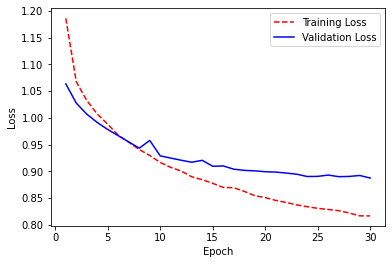

In [93]:
# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [94]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)
print(multiclass_roc_auc_score(y_test, y_pred))

0.672143080837919


In [0]:
model.save_weights("/content/1104370_1dconv_reg.h5")